First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
!conda create -n BI2025 python=3.11 -y
!conda activate BI2025
!pip install -r requirements.txt

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
  Cloning https://github.com/GreenfishK/starvers.git to /tmp/pip-install-x905r2d9/starvers_ac9866ba8c2a474caf2abfe7a9e80b93
  Running command git clone --filter=blob:none --quiet https://github.com/GreenfishK/starvers.git /tmp/pip-install-x905r2d9/starvers_ac9866ba8c2a474caf2abfe7a9e80b93
  Resolved https://github.com/GreenfishK/starvers.git to commit 1afb12052c2c762cb1c34d5e82666eddb23e3313
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
import uuid
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
executed_by ='stud-id_12434679'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '26'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12448457'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12434679'  # Replace the digits after "id_" with student B's student ID

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

In [6]:
# Helper to robustly insert triples into the SPARQL endpoint.
# It retries on exceptions, reduces chunk_size on each retry, and logs details.
import time

def safe_insert(engine, triples, prefixes=None, chunk_size=50, retries=4, backoff=1.5):
    """Insert triples with retries and exponential backoff.
    Params:
      engine: TripleStoreEngine instance
      triples: list of triple strings
      prefixes: dict of prefixes (optional)
      chunk_size: initial chunk size for insertion
      retries: number of attempts before giving up
      backoff: base multiplier for sleep between retries
    """
    attempt = 0
    while True:
        try:
            engine.insert(triples, prefixes=prefixes, chunk_size=chunk_size)
            return
        except Exception as e:
            attempt += 1
            # Show the exception object so the user can see HTTP status and message
            print(f"safe_insert attempt {attempt} failed: {e!r}")
            if attempt >= retries:
                print("Max retries reached — re-raising exception")
                raise
            # reduce chunk size to try to avoid gateway/timeouts on large payloads
            chunk_size = max(1, int(chunk_size / 2))
            sleep_time = backoff ** attempt
            print(f"Retrying in {sleep_time:.1f}s with chunk_size={chunk_size}...")
            time.sleep(sleep_time)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    import datetime
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

In [9]:
now()

'2025-12-15T19:24:41.545Z'

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [10]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Aron" .',
f':{student_a} foaf:familyName "Smith" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "َAmir" .',
f':{student_b} foaf:familyName "Saadati" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "12434679" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


safe_insert(engine, reigstration_triples_a, prefixes=prefixes, chunk_size=50)
safe_insert(engine, reigstration_triples_b, prefixes=prefixes, chunk_size=50)
safe_insert(engine, role_triples, prefixes=prefixes, chunk_size=50)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [11]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [12]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
...Data source and Scenario description:
Data source: The dataset is the 'House Sales in King County, USA' from Kaggle, containing 21,613 real
house sales records in King County, Washington (Seattle area). It includes 21 attributes
: id, date, price (target), bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront (binary),
view (ordinal 0-4), condition (ordinal 1-5), grade (ordinal 1-13), sqft_above, sqft_basement, yr_built,
yr_renovated, zipcode (categorical), lat,  long (continuous), sqft_living15, sqft_lot15. All features 
are interpretable real-estate semantics with variety: continuous numeric (sqft, lat/long), discrete numeric (bedrooms),
ordinal (condition, grade), binary (waterfront), categorical (zipcode), temporal (date, yr_built).
No artificial/synthesized data; real public assessor records.

Scenario: A real estate agency in Seattle aims to build a predictive tool for house prices to assist clients in 
selling decisions, reducing over/under-valuation risks in a competitive market influenced by tech boom 
...
"""

business_objectives_comment = """
1.Develop a robust predictive model that accurately predict house sale prices in USA
 based on property features such as  square footage, number of rooms, condition, waterfront to
support real-estate pricing decisions.

2.Analyze which property characteristics (e.g location, grade, renovations, size) 
have the most influence on sale price to help stakeholders understand market determinants.
...
"""

business_success_criteria_comment = """
1.The developed model is considered successful if it predicts house sale prices with high accuracy,
 measured by achieving an R² score of at least 0.75 and a reasonably low RMSE on a held-out test dataset,
 ensuring reliable price estimation for decision-making.
2.The analysis successfully shows which property features have the biggest impact on house prices, such as
 living area, location, grade, and condition. These results are easy to understand, statistically reliable,
 and consistent with how the real-estate market typically works.
...
"""

data_mining_goals_comment = """
1.Develop and compare supervised regression models(Linear Regression, XGBoost / Gradient Boosting, etc) to predict house sale prices based on structural, 
locational, and condition-related property features.

2.Perform exploratory and statistical analysis to quantify relationships between input variables and 
sale price, and to identify the most influential predictors.

3.Apply appropriate data preprocessing techniques, including missing value handling, outlier treatment,
 feature encoding, and normalization, to ensure model robustness and validity.

Data mining problem type: Supervised learning – Regression
...
"""

data_mining_success_criteria_comment = """

1. Accuracy:
The regression model predicts house prices with high accuracy, achieving R² ≥ 0.75 and low RMSE/MAE on 
the test set.

2.Feature Interpretability:
The model clearly identifies the most important property features affecting price (e.g., living area, 
location, grade), and these are consistent with domain knowledge.

3.Model Robustness:
The model performs consistently across training and test sets, with minimal overfitting and stable 
results under validation.
...
"""

ai_risk_aspects_comment = """
This model can create unfair outcomes because location information like zipcode and latitude longitude can indirectly reflect
socioeconomic patterns, so some areas may be consistently valued higher or lower.

There is also a risk of misuse and over reliance. A predicted price should support decisions, not replace an appraisal, and it
is important to communicate uncertainty instead of presenting one number as “the truth”.

Another risk is that the dataset is from 2014 to 2015 and housing markets change. If someone wanted to use this in practice,
the model would need retraining and monitoring over time.

Finally, precise location can be sensitive, so we should be careful when sharing data and results.
"""


bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [15]:
cyclists_data_path = ""
load_cycling_data_code_writer = student_a
def load_cycling_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(cyclists_data_path, 'kc_house_data.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)
    
    def create_date_index(dataframe: pd.DataFrame):
    # create year, month, and day columns
        index_cols = ['year', 'month', 'day']
        dataframe['date'] = pd.to_datetime(dataframe['date'], dayfirst=False, yearfirst=True)
        dataframe['year'] = dataframe['date'].dt.year
        dataframe['month'] = dataframe['date'].dt.month
        dataframe['day'] = dataframe['date'].dt.day

        dataframe.sort_values(index_cols, ascending = [True for _ in index_cols], inplace = True)
        dataframe.set_index(index_cols, inplace = True)
        dataframe.index.set_names(index_cols, inplace = True)
        return dataframe

    loaded_data = raw_data
    loaded_data['day_of_week'] = pd.to_datetime(loaded_data['date']).dt.day_name()
    loaded_data = create_date_index(loaded_data)
    
    return loaded_data

start_time_ld = now()
data = load_cycling_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_cycling_data_executor = [
    f':load_cycling_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_cycling_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all cycling data and create a hierarchical index (year, month, day). 
"""
load_cycling_data_activity = [
    ':load_cycling_data rdf:type prov:Activity .',
    ':load_cycling_data sc:isPartOf :data_understanding_phase .',
    ':load_cycling_data rdfs:comment \'Data Understanding\' .',
    f':load_cycling_data rdfs:comment """{ld_report}""" .', 
    f':load_cycling_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_cycling_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_cycling_data prov:used :raw_data .',
    ':load_cycling_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_cycling_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_cycling_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'King County House Sales, US\' .',
    ':raw_data sc:description \'House sales in King County, USA (May 2014 - May 2015). Contains 21,613 houses with 21 features including price, bedrooms, sqft, location, etc..\' .',
    # Continue with futher information about the dataset...
    ':kc_house_csv rdf:type cr:FileObject .',
    ':kc_house_csv sc:name \'kc_house_data.csv\' .',
    ':kc_house_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :kc_house_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'House sales records\' .',
    ':raw_recordset cr:source :kc_house_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
   ':raw_recordset cr:field :field_id .',
    ':raw_recordset cr:field :field_date .',
    ':raw_recordset cr:field :field_price .',
    ':raw_recordset cr:field :field_bedrooms .',
    ':raw_recordset cr:field :field_bathrooms .',
    ':raw_recordset cr:field :field_sqft_living .',
    ':raw_recordset cr:field :field_sqft_lot .',
    ':raw_recordset cr:field :field_floors .',
    ':raw_recordset cr:field :field_waterfront .',
    ':raw_recordset cr:field :field_view .',
    ':raw_recordset cr:field :field_condition .',
    ':raw_recordset cr:field :field_grade .',
    ':raw_recordset cr:field :field_sqft_above .',
    ':raw_recordset cr:field :field_sqft_basement .',
    ':raw_recordset cr:field :field_yr_built .',
    ':raw_recordset cr:field :field_yr_renovated .',
    ':raw_recordset cr:field :field_zipcode .',
    ':raw_recordset cr:field :field_lat .',
    ':raw_recordset cr:field :field_long .',
    ':raw_recordset cr:field :field_sqft_living15 .',
    ':raw_recordset cr:field :field_sqft_lot15 .',
    


    # Describe fields
    ':field_id rdf:type cr:Field .',
    ':field_id sc:name "id" .',
    ':field_id sc:description "Unique identifier for each house sale" .',
    ':field_id cr:dataType xsd:long .',

    ':field_date rdf:type cr:Field .',
    ':field_date sc:name "date" .',
    ':field_date sc:description "Date when the house was sold (format: YYYYMMDDT000000)" .',
    ':field_date cr:dataType xsd:date .',

    ':field_price rdf:type cr:Field .',
    ':field_price sc:name "price" .',
    ':field_price sc:description "Sale price of the house in US dollars (target variable for regression)" .',
    ':field_price cr:dataType xsd:decimal .',

    ':field_bedrooms rdf:type cr:Field .',
    ':field_bedrooms sc:name "bedrooms" .',
    ':field_bedrooms sc:description "Number of bedrooms in the house" .',
    ':field_bedrooms cr:dataType xsd:integer .',

    ':field_bathrooms rdf:type cr:Field .',
    ':field_bathrooms sc:name "bathrooms" .',
    ':field_bathrooms sc:description "Number of bathrooms (quarters indicate half-baths, etc.)" .',
    ':field_bathrooms cr:dataType xsd:decimal .',

    ':field_sqft_living rdf:type cr:Field .',
    ':field_sqft_living sc:name "sqft_living" .',
    ':field_sqft_living sc:description "Square footage of the interior living space" .',
    ':field_sqft_living cr:dataType xsd:integer .',

    ':field_sqft_lot rdf:type cr:Field .',
    ':field_sqft_lot sc:name "sqft_lot" .',
    ':field_sqft_lot sc:description "Square footage of the land/lot space" .',
    ':field_sqft_lot cr:dataType xsd:integer .',

    ':field_floors rdf:type cr:Field .',
    ':field_floors sc:name "floors" .',
    ':field_floors sc:description "Total number of floors in the house" .',
    ':field_floors cr:dataType xsd:decimal .',

    ':field_waterfront rdf:type cr:Field .',
    ':field_waterfront sc:name "waterfront" .',
    ':field_waterfront sc:description "Whether the house has a waterfront view (1: yes, 0: no)" .',
    ':field_waterfront cr:dataType xsd:boolean .',

    ':field_view rdf:type cr:Field .',
    ':field_view sc:name "view" .',
    ':field_view sc:description "Quality of the view from the house (rated 0-4, 0: none, 4: excellent)" .',
    ':field_view cr:dataType xsd:integer .',

    ':field_condition rdf:type cr:Field .',
    ':field_condition sc:name "condition" .',
    ':field_condition sc:description "Overall condition of the house (rated 1-5, 1: poor, 5: very good)" .',
    ':field_condition cr:dataType xsd:integer .',

    ':field_grade rdf:type cr:Field .',
    ':field_grade sc:name "grade" .',
    ':field_grade sc:description "Overall grade given to the house based on King County grading system (1-13, higher is better construction and design)" .',
    ':field_grade cr:dataType xsd:integer .',

    ':field_sqft_above rdf:type cr:Field .',
    ':field_sqft_above sc:name "sqft_above" .',
    ':field_sqft_above sc:description "Square footage of the house apart from the basement" .',
    ':field_sqft_above cr:dataType xsd:integer .',

    ':field_sqft_basement rdf:type cr:Field .',
    ':field_sqft_basement sc:name "sqft_basement" .',
    ':field_sqft_basement sc:description "Square footage of the basement" .',
    ':field_sqft_basement cr:dataType xsd:integer .',

    ':field_yr_built rdf:type cr:Field .',
    ':field_yr_built sc:name "yr_built" .',
    ':field_yr_built sc:description "Year when the house was originally built" .',
    ':field_yr_built cr:dataType xsd:integer .',

    ':field_yr_renovated rdf:type cr:Field .',
    ':field_yr_renovated sc:name "yr_renovated" .',
    ':field_yr_renovated sc:description "Year of the last renovation (0 if never renovated)" .',
    ':field_yr_renovated cr:dataType xsd:integer .',

    ':field_zipcode rdf:type cr:Field .',
    ':field_zipcode sc:name "zipcode" .',
    ':field_zipcode sc:description "ZIP code of the house location" .',
    ':field_zipcode cr:dataType xsd:string .',

    ':field_lat rdf:type cr:Field .',
    ':field_lat sc:name "lat" .',
    ':field_lat sc:description "Latitude coordinate of the house" .',
    ':field_lat cr:dataType xsd:decimal .',

    ':field_long rdf:type cr:Field .',
    ':field_long sc:name "long" .',
    ':field_long sc:description "Longitude coordinate of the house" .',
    ':field_long cr:dataType xsd:decimal .',

    ':field_sqft_living15 rdf:type cr:Field .',
    ':field_sqft_living15 sc:name "sqft_living15" .',
    ':field_sqft_living15 sc:description "Average square footage of interior living space for the 15 nearest neighbors (in 2015)" .',
    ':field_sqft_living15 cr:dataType xsd:integer .',

    ':field_sqft_lot15 rdf:type cr:Field .',
    ':field_sqft_lot15 sc:name "sqft_lot15" .',
    ':field_sqft_lot15 sc:description "Average square footage of land/lot for the 15 nearest neighbors (in 2015)" .',
    ':field_sqft_lot15 cr:dataType xsd:integer .',

]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [


    ':data rdf:type sc:Dataset .',
    ':data sc:name "Loaded King County House Sales Dataset" .',

    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Loaded House Sales Records" .',
    ':data cr:recordSet :recordset .',

    ':recordset cr:field :field_id .',
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_price .',
    ':recordset cr:field :field_bedrooms .',
    ':recordset cr:field :field_bathrooms .',
    ':recordset cr:field :field_sqft_living .',
    ':recordset cr:field :field_sqft_lot .',
    ':recordset cr:field :field_floors .',
    ':recordset cr:field :field_waterfront .',
    ':recordset cr:field :field_view .',
    ':recordset cr:field :field_condition .',
    ':recordset cr:field :field_grade .',
    ':recordset cr:field :field_sqft_above .',
    ':recordset cr:field :field_sqft_basement .',
    ':recordset cr:field :field_yr_built .',
    ':recordset cr:field :field_yr_renovated .',
    ':recordset cr:field :field_zipcode .',
    ':recordset cr:field :field_lat .',
    ':recordset cr:field :field_long .',
    ':recordset cr:field :field_sqft_living15 .',
    ':recordset cr:field :field_sqft_lot15 .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_price qudt:unit qudt:USD .',           
    ':field_sqft_living qudt:unit qudt:FT2 .',     
    ':field_sqft_lot qudt:unit qudt:FT2 .',
    ':field_sqft_above qudt:unit qudt:FT2 .',
    ':field_sqft_basement qudt:unit qudt:FT2 .',
    ':field_sqft_living15 qudt:unit qudt:FT2 .',
    ':field_sqft_lot15 qudt:unit qudt:FT2 .',
]
engine.insert(units_triples, prefixes=prefixes)

id       date      price  bedrooms  bathrooms  \
year month day                                                          
2014 5     2    1999700045 2014-05-02   313000.0         3       1.50   
           2    1860600135 2014-05-02  2380000.0         5       2.50   
           2    5467900070 2014-05-02   342000.0         3       2.00   
           2    4040800810 2014-05-02   420000.0         3       2.25   
           2    7197300105 2014-05-02   550000.0         4       2.50   

                sqft_living  sqft_lot  floors  waterfront  view  ...  \
year month day                                                   ...   
2014 5     2           1340      7912     1.5           0     0  ...   
           2           3650      9050     2.0           0     4  ...   
           2           1930     11947     1.0           0     0  ...   
           2           2000      8030     1.0           0     0  ...   
           2           1940     10500     1.0           0     0  ...   

                sqft_above  sqft_basement  yr_built  yr_renovated  zipcode  \
year month day                                                               
2014 5     2          1340              0      1955             0    98133   
           2          3370            280      1921             0    98119   
           2          1930              0      1966             0    98042   
           2          1000           1000      1963             0    98008   
           2          1140            800      1976             0    98052   

                    lat     long  sqft_living15  sqft_lot15  day_of_week  
year month day                                                            
2014 5     2    47.7658 -122.339           1480        7940       Friday  
           2    47.6345 -122.367           2880        5400       Friday  
           2    47.3672 -122.151           2200       12825       Friday  
           2    47.6188 -122.114           2070        8250       Friday  
           2    47.6830 -122.114           2200       10500       Friday  

[5 rows x 22 columns]

In [16]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, columns: list, factor: float = 2.5) -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING

    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)
    
    for col in columns:
        Q1 = tmp[col].quantile(0.25)
        Q3 = tmp[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Find outlier rows
        outlier_mask = (tmp[col] < lower_bound) | (tmp[col] > upper_bound)
        outlier_indices = tmp[outlier_mask].index.tolist()
        
        outlier_details = [
            {
                "index": int(idx),
                "value": float(tmp.loc[idx, col]),
                "lower_bound": float(lower_bound),
                "upper_bound": float(upper_bound)
            }
            for idx in outlier_indices
        ]
        
        results[col] = {
            "num_outliers": len(outlier_indices),
            "lower_bound": float(lower_bound),
            "upper_bound": float(upper_bound),
            "details": outlier_details
        }
    
    return results


columns_to_check = ['price', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']

start_time_co = now()
outliers_report = check_outliers(data, columns=columns_to_check, factor=3)
end_time_co = now()

start_time_ho = now()
for col, info in outliers_report.items():
    print(f"\n{col}: {info['num_outliers']} outliers detected "
          f"(bounds: {info['lower_bound']:.2f} – {info['upper_bound']:.2f})")
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = str(uuid.uuid4())
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = str(uuid.uuid4())
co_comment = """
we detecte the outliers using the IQR method with factor=3.
This is a standard robust statistical approach suitable for skewed real estate data.
Columns analyzed: price, sqft_living, sqft_lot, bedrooms, bathrooms.
The method identifies values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = str(uuid.uuid4())
ior_comment = """
After looking at the IQR-based outlier analysis, its clear that a number of properties were flagged — including about 420 homes
priced above roughly $1.6M, 74 houses with exceptionally large living areas, and many properties with very large lot sizes. However,
these points are not errors in the data. They reflect real characteristics of the housing market, particularly the 
luxury segment and homes in more rural areas. High-end properties and large lots are a genuine and important part of the market,
especially in places like Medina, Mercer Island, and other low-density regions.

Decision:
Outliers will not be removed, as doing so would bias the model and reduce its ability to accurately predict high-value properties.

Instead, during the data preparation stage:

 1.A log transformation will be applied to variables such as price, sqft_living, and sqft_lot to reduce skewness.

 2.Tree-based models (e.g., Random Forest and XGBoost) will be preferred, since they are naturally more robust to extreme values.

This strategy keeps all meaningful market information while improving model stability and predictive performance.

"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)


price: 420 outliers detected (bounds: -647200.00 – 1614150.00)

sqft_living: 74 outliers detected (bounds: -1942.00 – 5919.00)

sqft_lot: 1771 outliers detected (bounds: -11904.00 – 27632.00)

bedrooms: 24 outliers detected (bounds: 0.00 – 7.00)

bathrooms: 64 outliers detected (bounds: -0.50 – 4.75)


**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

/tmp/ipykernel_4115/3437170989.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, ax=ax, palette='viridis')
/tmp/ipykernel_4115/3437170989.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, ax=ax, palette='viridis')
/tmp/ipykernel_4115/3437170989.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, ax=ax, palette='viridis')
/tmp/ipykernel_4115/3437170989.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x`

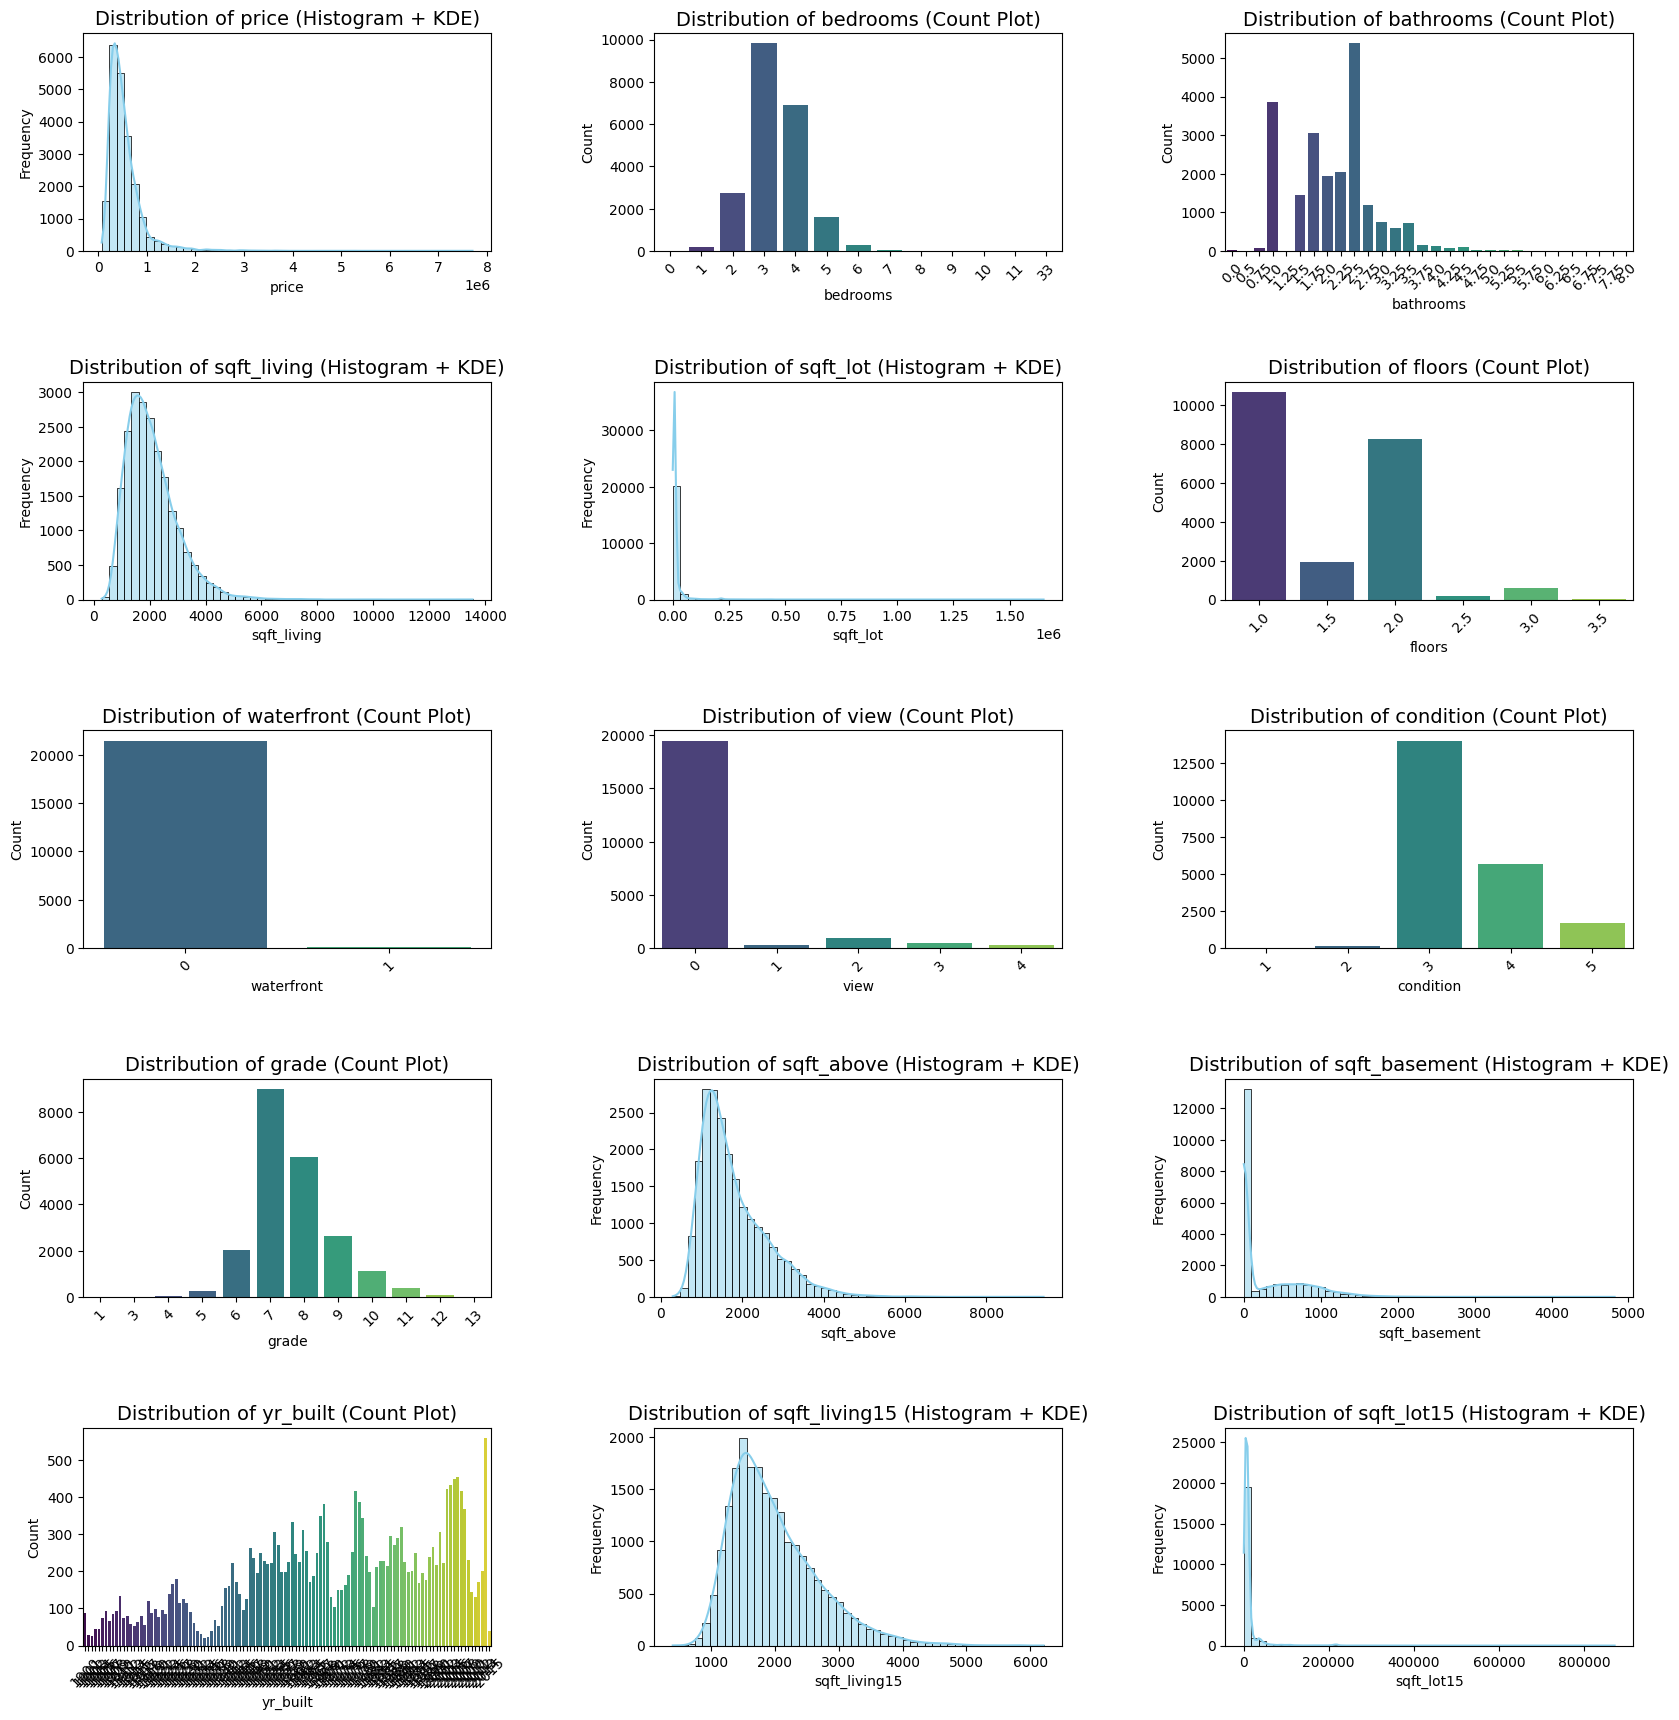

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import uuid

dist_all_code_writer = student_a  


start_time_dist_all = now()

columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement', 'yr_built',
               'sqft_living15', 'sqft_lot15']

# Categorical
categorical_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 
                    'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']

# Numerical
numerical_cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 
                  'sqft_basement', 'sqft_living15', 'sqft_lot15']

# Special handling
date_col = 'date'

# Execute comprehensive visualization

fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(len(columns)//3 + 2, 3, wspace=0.4, hspace=0.6)
plot_idx = 0

for col in columns:
    ax = fig.add_subplot(grid[plot_idx])
    
    if col in categorical_cols:
        # Count plot for categorical/ordinal
        sns.countplot(data=data, x=col, ax=ax, palette='viridis')
        ax.set_title(f'Distribution of {col} (Count Plot)', fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
    
    elif col in numerical_cols:
        # Histogram + KDE for numerical
        sns.histplot(data=data, x=col, kde=True, ax=ax, color='skyblue', bins=50)
        ax.set_title(f'Distribution of {col} (Histogram + KDE)', fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    
    
    plot_idx += 1

plt.savefig('all_distributions.png', dpi=300, bbox_inches='tight')
end_time_dist_all = now()

dist_all_ass_uuid_executor = str(uuid.uuid4())
dist_all_ass_uuid_writer = str(uuid.uuid4())



dist_all_executor_triples = [
    f':visualize_all_distributions prov:qualifiedAssociation :{dist_all_ass_uuid_executor} .',
    f':{dist_all_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dist_all_ass_uuid_executor} rdf:type prov:Association .',
    f':{dist_all_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(dist_all_executor_triples, prefixes=prefixes)

dist_all_comment = """
The price, living space (sqft_living), lot size (sqft_lot), and related area features are clearly right-skewed with 
long tails, which is expected given the presence of luxury homes and large estates. Most houses fall into more typical
ranges: bedrooms are concentrated around 3–4, bathrooms around 2.25–2.5, floors are usually 1–2, and grades are mainly
centered between 7 and 8, showing that mid-range homes dominate the dataset.

Waterfront properties are very rare, leading to a strong class imbalance. Similarly, most homes have no special view or
only an average one, and condition ratings are mostly fair to good. Basement space is zero for a large portion of the houses,
while the year-built feature shows increasing construction activity over time, particularly after 1950. Only a small fraction
 of homes have been renovated.

The features sqft_living15 and sqft_lot15 follow the same skewed patterns as their corresponding original variables.
"""

dist_all_activity_triples = [
    ':visualize_all_distributions rdf:type prov:Activity .',
    ':visualize_all_distributions sc:isPartOf :data_understanding_phase .',
    ':visualize_all_distributions rdfs:comment "Data Understanding - Full Distribution Analysis of All Attributes" .',
    f':visualize_all_distributions rdfs:comment """{dist_all_comment}""" .',
    f':visualize_all_distributions prov:startedAtTime "{start_time_dist_all}"^^xsd:dateTime .',
    f':visualize_all_distributions prov:endedAtTime "{end_time_dist_all}"^^xsd:dateTime .',
    f':visualize_all_distributions prov:qualifiedAssociation :{dist_all_ass_uuid_writer} .',
    f':{dist_all_ass_uuid_writer} prov:agent :{dist_all_code_writer} .',
    f':{dist_all_ass_uuid_writer} rdf:type prov:Association .',
    f':{dist_all_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':visualize_all_distributions prov:used :data .',
    ':all_distributions_plot rdf:type prov:Entity .',
    ':all_distributions_plot rdfs:comment "Comprehensive grid visualization of distributions for all 21 attributes." .',
    ':all_distributions_plot prov:wasGeneratedBy :visualize_all_distributions .',
]
engine.insert(dist_all_activity_triples, prefixes=prefixes)



In [18]:
plausibility_code_writer = student_a  

def check_plausibility(df: pd.DataFrame) -> dict:
   
    issues = {}
    
    if (df['price'] <= 0).any():
        issues['price'] = f"{(df['price'] <= 0).sum()} houses with price <= 0 (impossible)"
    
    if (df['bedrooms'] < 0).any():
        issues['bedrooms'] = f"{(df['bedrooms'] < 0).sum()} negative bedrooms"
    
    if (df['bathrooms'] < 0).any():
        issues['bathrooms'] = f"{(df['bathrooms'] < 0).sum()} negative bathrooms"
    
    if (df['sqft_living'] <= 0).any():
        issues['sqft_living'] = f"{(df['sqft_living'] <= 0).sum()} houses with zero or negative living space"
    
    if (df['sqft_lot'] <= 0).any():
        issues['sqft_lot'] = f"{(df['sqft_lot'] <= 0).sum()} zero or negative lot size"
    
    current_year = 2025
    if (df['yr_built'] > current_year).any():
        issues['yr_built'] = f"{(df['yr_built'] > current_year).sum()} houses built in the future (>2025)"
    
    if (df['yr_built'] < 1800).any():  
        issues['yr_built_too_old'] = f"{(df['yr_built'] < 1800).sum()} houses built before 1800 (unlikely)"
    
    if (df['yr_renovated'] > current_year).any() and (df['yr_renovated'] != 0).any():
        renovated_future = df[(df['yr_renovated'] > current_year) & (df['yr_renovated'] != 0)]
        issues['yr_renovated'] = f"{len(renovated_future)} houses renovated in the future"
    
    if (df['yr_renovated'] < df['yr_built']).any() and (df['yr_renovated'] != 0).any():
        invalid_renov = df[(df['yr_renovated'] < df['yr_built']) & (df['yr_renovated'] != 0)]
        issues['yr_renovated_before_built'] = f"{len(invalid_renov)} cases where renovation year < construction year"
    
   
   
    return issues

start_time_plaus = now()
plausibility_report = check_plausibility(data)
end_time_plaus = now()

print("Plausibility Check Report:")
for key, msg in plausibility_report.items():
    print(f"- {key}: {msg}")

#############################################
# Provenance Documentation
#############################################

plaus_ass_uuid_executor = str(uuid.uuid4())
plaus_ass_uuid_writer = str(uuid.uuid4())

# plaus_executor_triples = [
#     f':check_plausibility prov:qualifiedAssociation :{plaus_ass_uuid_executor} .',
#     f':{plaus_ass_uuid_executor} prov:agent :{executed_by} .',
#     f':{plaus_ass_uuid_executor} rdf:type prov:Association .',
#     f':{plaus_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
# ]
# engine.insert(plaus_executor_triples, prefixes=prefixes)

# plaus_comment = """

# """

# plaus_activity_triples = [
#     ':check_plausibility rdf:type prov:Activity .',
#     ':check_plausibility sc:isPartOf :data_understanding_phase .',
#     ':check_plausibility rdfs:comment "Data Understanding - Plausibility of Values Check" .',
#     f':check_plausibility rdfs:comment """{plaus_comment}""" .',
#     f':check_plausibility prov:startedAtTime "{start_time_plaus}"^^xsd:dateTime .',
#     f':check_plausibility prov:endedAtTime "{end_time_plaus}"^^xsd:dateTime .',
#     f':check_plausibility prov:qualifiedAssociation :{plaus_ass_uuid_writer} .',
#     f':{plaus_ass_uuid_writer} prov:agent :{plausibility_code_writer} .',
#     f':{plaus_ass_uuid_writer} rdf:type prov:Association .',
#     f':{plaus_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
#     ':check_plausibility prov:used :data .',
#     ':plausibility_report rdf:type prov:Entity .',
#     f':plausibility_report rdfs:comment """Plausibility check results: """ .',
#     ':plausibility_report prov:wasGeneratedBy :check_plausibility .',
# ]
# engine.insert(plaus_activity_triples, prefixes=prefixes)

# plaus_decision_comment = """
# No implausible values requiring correction were found.
# Data is consistent with real-world residential property records in King County.
# No cleansing actions needed for illogical values.
# Proceed to modeling with confidence in data integrity.
# """

# decision_triples = [
#     ':plausibility_decision rdf:type prov:Entity .',
#     f':plausibility_decision rdfs:comment """{plaus_decision_comment}""" .',
#     ':plausibility_decision prov:wasDerivedFrom :plausibility_report .',
#     ':data_understanding_phase rdfs:comment "Plausibility check confirms high data quality; no corrections needed beyond planned transformations for skewness." .',
# ]
# engine.insert(decision_triples, prefixes=prefixes)

Plausibility Check Report:
- yr_renovated_before_built: 0 cases where renovation year < construction year


## Data Preparation

In [19]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [20]:
handle_outliers_code_writer = student_b

def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    
    tmp = df.copy()

    # 1) Remove invalid bathrooms (<= 0). Decimal bathrooms remain untouched (e.g., 1.25, 1.5, 1.75, ...).
    tmp = tmp[tmp["bathrooms"] > 0].copy()

    # 2) Remove implausible bedrooms count (33 bedrooms).
    # Reason: with typical living area, 33 bedrooms would imply unrealistically tiny rooms -> likely a typo (e.g., 3).
    tmp = tmp[tmp["bedrooms"] != 33].copy()

    return tmp

start_time_td = now()
cleaned_data = handle_outliers(data, outliers_report)   # IMPORTANT: save result
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Cleaning decision (conservative):

1) We remove records with bathrooms <= 0.
   - In our data there are only a few such rows, and all of them have positive living area (sqft_living > 0) and realistic prices.
   - Therefore, bathrooms=0 is not plausible for actual houses and most likely represents missing or erroneous data.
   - Removing them improves data quality and has negligible impact on the overall distribution.

2) We keep decimal bathroom values (e.g., 1.25, 1.5, 1.75).
   - Decimal bathrooms are normal in real-estate datasets because they encode partial bathrooms (half/three-quarter baths).

3) We remove the single record with 33 bedrooms.
   - Given its normal living area and price, 33 bedrooms is not realistic and is very likely a data-entry error (e.g., '3' was recorded as '33').
"""

handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .',
    f':handle_outliers rdfs:comment """{td_comment}""" .',
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [26]:
RANDOM_STATE = 42
TARGET = "price"
ID_COL = "id"
DATE_COL = "date"

In [27]:
df_raw = data.reset_index().copy()
ID_COL = "id"

df = df_raw.copy()

# Missing values
total_missing = int(df.isna().sum().sum())
print("Total missing values in dataset:", total_missing)

# Exact duplicate rows
dup_rows = int(df.duplicated().sum())
print("Exact duplicate rows:", dup_rows)

# Repeated IDs (important for split strategy)
if ID_COL in df.columns:
    repeats = df[ID_COL].value_counts()
    repeated_ids = int((repeats > 1).sum())
    max_repeat = int(repeats.max())
    print(f"Repeated house IDs (>1 appearance): {repeated_ids}")
    print(f"Max times the same house appears: {max_repeat}")

Total missing values in dataset: 0
Exact duplicate rows: 0
Repeated house IDs (>1 appearance): 176
Max times the same house appears: 3


In [30]:
DATE_COL = "date"

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
n_nat = int(df[DATE_COL].isna().sum())
print("Invalid dates (NaT):", n_nat)

df["sale_year"] = df[DATE_COL].dt.year.astype("Int64")
df["sale_month"] = df[DATE_COL].dt.month.astype("Int64")
df["sale_day"] = df[DATE_COL].dt.day.astype("Int64")

display(df[[DATE_COL, "sale_year", "sale_month", "sale_day"]].head(3))

Invalid dates (NaT): 0


,date,sale_year,sale_month,sale_day
0,2014-05-02,2014,5,2
1,2014-05-02,2014,5,2
2,2014-05-02,2014,5,2


In [31]:
DROP_AFTER_SPLIT = [ID_COL]   # use for split, then drop from X
DROP_AFTER_FE = [DATE_COL]    # drop raw date after extracting features

diff = (df["sqft_above"] + df["sqft_basement"]) - df["sqft_living"]
share_zero = float((diff == 0).mean())

print(diff.describe())
print("Share exactly zero:", share_zero)
print("All rows exactly zero?:", bool((diff == 0).all()))

# Output-based decision:
if (diff == 0).all():
    DROP_AFTER_FE.append("sqft_above")
    print("Decision: dropping `sqft_above` (perfectly redundant).")
else:
    print("Decision: keeping `sqft_above` (not perfectly redundant).")

print("DROP_AFTER_SPLIT:", DROP_AFTER_SPLIT)
print("DROP_AFTER_FE:", DROP_AFTER_FE)

count    21613.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64
Share exactly zero: 1.0
All rows exactly zero?: True
Decision: dropping `sqft_above` (perfectly redundant).
DROP_AFTER_SPLIT: ['id']
DROP_AFTER_FE: ['date', 'sqft_above']


In [32]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(df, groups=df[ID_COL]))

train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)
print("ID overlap:", len(set(train_df[ID_COL]).intersection(set(test_df[ID_COL]))))

# We train on log1p(price) (original price kept separate for reporting).
y_train = train_df[TARGET].copy()
y_test = test_df[TARGET].copy()

# Keep original target too (useful later to report metrics in real dollars)
y_train_price = y_train.copy()
y_test_price = y_test.copy()

if (y_train_price < 0).any() or (y_test_price < 0).any():
    raise ValueError("Target price has negative values; cannot apply log1p safely.")

y_train = np.log1p(y_train_price)
y_test = np.log1p(y_test_price)

print("Target transformed: y_train/y_test are now log1p(price).")

X_train = train_df.drop(columns=[TARGET]).copy()
X_test = test_df.drop(columns=[TARGET]).copy()

# Drop ID after splitting
X_train = X_train.drop(columns=DROP_AFTER_SPLIT)
X_test = X_test.drop(columns=DROP_AFTER_SPLIT)

# Drop feature-engineering drops (raw date + maybe sqft_above)
X_train = X_train.drop(columns=DROP_AFTER_FE)
X_test = X_test.drop(columns=DROP_AFTER_FE)

print("After drops -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("Remaining columns:", list(X_train.columns))

Train shape: (17289, 28) Test shape: (4324, 28)
ID overlap: 0
Target transformed: y_train/y_test are now log1p(price).
After drops -> X_train: (17289, 24) X_test: (4324, 24)
Remaining columns: ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day_of_week', 'sale_year', 'sale_month', 'sale_day']


In [33]:
# 1) quick missing check
miss_train = X_train.isna().mean().sort_values(ascending=False)
miss_test = X_test.isna().mean().sort_values(ascending=False)

print("Top missing (train):")
print(miss_train[miss_train > 0].head(20))

print("\nTop missing (test):")
print(miss_test[miss_test > 0].head(20))

# 2) explicit feature groups
cat_cols = ["zipcode"]
binary_cols = ["waterfront"]
ordinal_cols = ["view", "condition", "grade"]

# ensure correct dtype for categorical
X_train["zipcode"] = X_train["zipcode"].astype(str)
X_test["zipcode"] = X_test["zipcode"].astype(str)

excluded = set(cat_cols + binary_cols + ordinal_cols)
num_cols = [c for c in X_train.columns if c not in excluded]

print("\nCategorical:", cat_cols)
print("Binary:", binary_cols)
print("Ordinal:", ordinal_cols)
print("Numeric:", num_cols)

print("\nzipcode nunique (train):", X_train["zipcode"].nunique())
print("waterfront unique values (train):", sorted(X_train["waterfront"].unique()))

Top missing (train):
Series([], dtype: float64)

Top missing (test):
Series([], dtype: float64)

Categorical: ['zipcode']
Binary: ['waterfront']
Ordinal: ['view', 'condition', 'grade']
Numeric: ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day_of_week', 'sale_year', 'sale_month', 'sale_day']

zipcode nunique (train): 70
waterfront unique values (train): [np.int64(0), np.int64(1)]


In [40]:
# Log-transform skewed “size” features (matches colleague decision)
LOG_FEATURES = ["sqft_living", "sqft_lot"]

for col in LOG_FEATURES:
    if col in X_train.columns:
        # safety check: must be >= 0 for log1p
        if (X_train[col] < 0).any() or (X_test[col] < 0).any():
            raise ValueError(f"{col} has negative values; cannot apply log1p safely.")
        X_train[col] = np.log1p(X_train[col])
        X_test[col] = np.log1p(X_test[col])

In [39]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# make sure day_of_week is not sent to StandardScaler
if "day_of_week" in X_train.columns:
    if "day_of_week" not in cat_cols:
        cat_cols = cat_cols + ["day_of_week"]
    X_train["day_of_week"] = X_train["day_of_week"].astype(str)
    X_test["day_of_week"] = X_test["day_of_week"].astype(str)

# safety: keep only truly numeric columns in num_cols
num_cols = [c for c in num_cols if pd.api.types.is_numeric_dtype(X_train[c])]

scale_cols = num_cols + ordinal_cols

preprocess = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), scale_cols),
        ("binary", "passthrough", binary_cols),
        ("zip", ohe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0,
    verbose_feature_names_out=False
)

preprocess.fit(X_train)

Xt_train = preprocess.transform(X_train)
Xt_test = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()

X_train_ready = pd.DataFrame(Xt_train, columns=feature_names, index=X_train.index)
X_test_ready = pd.DataFrame(Xt_test, columns=feature_names, index=X_test.index)

In [67]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [68]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [69]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [70]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [71]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [72]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [73]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [74]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [78]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [79]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [80]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [81]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [82]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
